In [1]:
# using Pkg
# Pkg.add(["DataFrames", "CSV", "Images", "FileIO", "Glob", "ImageIO"])


In [2]:
function load_classes(class_file::String)
    return readlines(class_file)
end

class_names = load_classes("_classes.txt")

12-element Vector{String}:
 "awning-tricycle"
 "bicycle"
 "bus"
 "car"
 "motor"
 "object"
 "others"
 "pedestrian"
 "people"
 "tricycle"
 "truck"
 "van"

In [3]:
using DataFrames
using CSV
using FileIO
using Images
using Glob


function parse_annotations(file::String)
    rows = String[]
    open(file, "r") do f
        for line in eachline(f)
            split_line = split(line)
            image_name = split_line[1]
            bboxes = split_line[2:end]
            for box in bboxes
                coords = split(box, ",")
                push!(rows, join([image_name; coords], ","))
            end
        end
    end
    df = CSV.read(IOBuffer(join(rows, "\n")), DataFrame, header=["image", "x1", "y1", "x2", "y2", "class_id"])
    # Convert coordinates and class_id to Int
    for col in [:x1, :y1, :x2, :y2, :class_id]
        df[!, col] = convert.(Int, df[!, col])
    end
    return df
end

annotations_df = parse_annotations("_annotations.txt")
first(annotations_df, 5)

Row,image,x1,y1,x2,y2,class_id
,String,Int64,Int64,Int64,Int64,Int64
1,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,247,384,294,440,3
2,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,172,365,223,424,3
3,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,314,523,380,617,3
4,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,89,270,129,320,3
5,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,48,225,84,274,3


In [4]:
annotations_df.class_name = [class_names[i+1] for i in annotations_df.class_id]
first(annotations_df, 5)


Row,image,x1,y1,x2,y2,class_id,class_name
,String,Int64,Int64,Int64,Int64,Int64,String
1,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,247,384,294,440,3,car
2,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,172,365,223,424,3,car
3,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,314,523,380,617,3,car
4,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,89,270,129,320,3,car
5,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,48,225,84,274,3,car


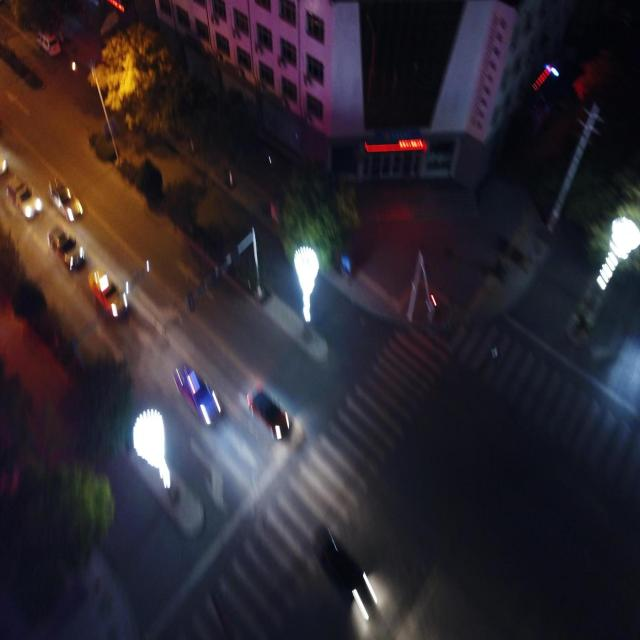

In [5]:
using Images, FileIO

function load_image(img_path::String)
    return load(img_path)
end

img_sample = load_image("images/" * annotations_df.image[1])


In [6]:
using Random

unique_images = unique(annotations_df.image)
Random.seed!(28)  
shuffle!(unique_images)

n = length(unique_images)
train_split = unique_images[1:round(Int, 0.8n)]
val_split   = unique_images[round(Int, 0.8n)+1:round(Int, 0.9n)]
test_split  = unique_images[round(Int, 0.9n)+1:end]

train_df = filter(row -> row.image in train_split, annotations_df)
val_df   = filter(row -> row.image in val_split, annotations_df)
test_df  = filter(row -> row.image in test_split, annotations_df)

first(train_df,5)

Row,image,x1,y1,x2,y2,class_id,class_name
,String,Int64,Int64,Int64,Int64,Int64,String
1,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,247,384,294,440,3,car
2,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,172,365,223,424,3,car
3,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,314,523,380,617,3,car
4,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,89,270,129,320,3,car
5,9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg,48,225,84,274,3,car


In [8]:
# using Pkg
# Pkg.add("Luxor")

In [85]:
annotations_path = "_annotations.txt"
classes_path = "_classes.txt"
images_dir = "images/"

"images/"

In [98]:
using Luxor

function draw_bounding_boxes(image_path::String, boxes::DataFrame)
    img = load(image_path)
    h, w = size(img) 
    img_rgb = colorview(RGB, img)

    @png begin
        background("white")
        placeimage(img_rgb)

        setline(2)
        sethue("red")

        for row in eachrow(boxes)
            x1, y1, x2, y2 = row.x1, row.y1, row.x2, row.y2
            rect(Point(x1, y1), x2 - x1, y2 - y1, :stroke)

            label = row.class_name
            fontsize(14)
            text(label, Point(x1 + 4, y1 - 4), halign=:left, valign=:bottom)
        end
    end
end


draw_bounding_boxes (generic function with 1 method)

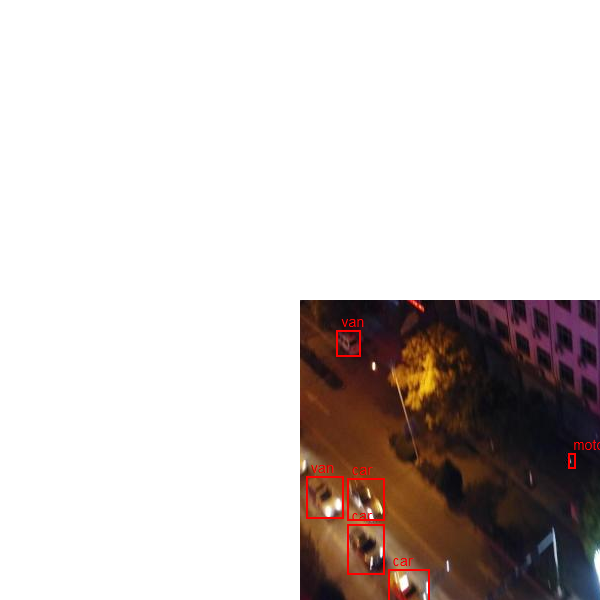

In [99]:
sample_image = train_df.image[1]
sample_path = images_dir * sample_image
sample_boxes = filter(row -> row.image == sample_image, train_df)

draw_bounding_boxes(sample_path, sample_boxes)


In [100]:
IMG_SIZE = 416         # Standard YOLO input size
S = 13                 # Output grid size (13x13)
B = 2                  # Number of boxes per cell
C = 12                 # Number of classes (from VisDrone)

12

In [104]:
# import Pkg; Pkg.add("Flux")

In [105]:
using Images, FileIO, Flux, DataFrames, Random

In [107]:
function load_and_resize(path::String, size::Int)
    img = load(path)
    if ndims(img) == 2  # grayscale
        img = colorview(RGB, img, img, img)
    end
    return imresize(img, (size, size))
end


load_and_resize (generic function with 1 method)

In [111]:
# (cx, cy, w, h, class_id) — all normalized to [0, 1]

In [112]:
function to_yolo_targets(df::DataFrame, img_size::Int)
    targets = []
    for row in eachrow(df)
        x1, y1, x2, y2 = row.x1, row.y1, row.x2, row.y2
        cx = (x1 + x2) / 2 / img_size
        cy = (y1 + y2) / 2 / img_size
        w  = (x2 - x1) / img_size
        h  = (y2 - y1) / img_size
        push!(targets, (cx, cy, w, h, row.class_id))
    end
    return targets
end


to_yolo_targets (generic function with 1 method)

In [115]:
image_name = "9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg"
sample_path = images_dir * image_name
sample_img = load_and_resize(sample_path, IMG_SIZE)
sample_annots = filter(row -> row.image == train_df.image[1], train_df)
sample_targets = to_yolo_targets(sample_annots, IMG_SIZE)

ArgumentError: ArgumentError: Color objects other than `AbstractGray` cannot be used as if they were `Real` arguments.

In [121]:
import Pkg
Pkg.add("ImageTransformations")


   Resolving package versions...
    Updating `E:\DBS\Deep Learning\Project.toml`
  [02fcd773] + ImageTransformations v0.10.2
  No Changes to `E:\DBS\Deep Learning\Manifest.toml`


In [122]:
using Images, ImageTransformations, FileIO, DataFrames
using ImageTransformations


# 1) your LOAD/RESIZE
function load_and_resize(path::String, size::Int)
    img = load(path)
    img = ndims(img)==2 ? colorview(RGB, img, img, img) : img
    chans = channelview(img)
    r, g, b = chans[1, :, :], chans[2, :, :], chans[3, :, :]
    r2, g2, b2 = imresize(r, (size,size)), imresize(g, (size,size)), imresize(b, (size,size))
    return colorview(RGB, r2, g2, b2)
end

# 2) minimal DataFrame & YOLO‐converter
train_df = DataFrame(image = ["a.jpg", "b.jpg"], x1=Int[], y1=Int[], x2=Int[], y2=Int[], class_id=Int[])
to_yolo_targets(df, img_size) = [( (row.x1+row.x2)/2/img_size,
                                   (row.y1+row.y2)/2/img_size,
                                   (row.x2-row.x1)/img_size,
                                   (row.y2-row.y1)/img_size,
                                   row.class_id )
                                 for row in eachrow(df)]

# 3) finally your “cell 15+16”
images_dir = "images/"
image_name  = "9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385c516f8aa985fd827b.jpg"
sample_path = images_dir * image_name
sample_img  = load_and_resize(sample_path, 416)

sample_annots  = filter(row -> row.image == image_name, train_df)
sample_targets = to_yolo_targets(sample_annots, 416)

println("Loaded sample image: ", size(sample_img))
println("YOLO targets: ", sample_targets)


DimensionMismatch: DimensionMismatch: column :image has length 2 and column :x1 has length 0

In [124]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. Install & load dependencies
# ───────────────────────────────────────────────────────────────────────────────
using Pkg
# If you haven’t installed these yet, uncomment:
# Pkg.add(["DataFrames", "CSV", "Images", "FileIO", "Glob", "ImageIO", "Luxor", "Flux", "Random", "ImageTransformations"])

using DataFrames, CSV, FileIO, Images, ImageTransformations, Glob, Luxor, Flux, Random

# ───────────────────────────────────────────────────────────────────────────────
# 2. Paths & constants
# ───────────────────────────────────────────────────────────────────────────────
classes_path     = "_classes.txt"
annotations_path = "_annotations.txt"
images_dir       = "images/"    # directory containing your JPEGs
IMG_SIZE         = 416          # YOLO input size

# ───────────────────────────────────────────────────────────────────────────────
# 3. Load class names
# ───────────────────────────────────────────────────────────────────────────────
function load_classes(class_file::String)
    return readlines(class_file)
end
class_names = load_classes(classes_path)

# ───────────────────────────────────────────────────────────────────────────────
# 4. Parse annotations into a DataFrame (safe conversion)
# ───────────────────────────────────────────────────────────────────────────────
function parse_annotations(file::String)
    rows = String[]
    open(file, "r") do io
        for line in eachline(io)
            parts   = split(line)
            img_name, bboxes = parts[1], parts[2:end]
            for box in bboxes
                coords = split(box, ",")
                push!(rows, join([img_name; coords], ","))
            end
        end
    end

    df = CSV.read(
        IOBuffer(join(rows, "\n")),
        DataFrame;
        header = ["image","x1","y1","x2","y2","class_id"]
    )

    # Now safely convert each entry to Int if it's a String
    for col in [:x1, :y1, :x2, :y2, :class_id]
        df[!, col] = [isa(v, String) ? parse(Int, v) : v for v in df[!, col]]
    end

    return df
end

annotations_df = parse_annotations(annotations_path)

# ───────────────────────────────────────────────────────────────────────────────
# 5. Attach class names
# ───────────────────────────────────────────────────────────────────────────────
annotations_df.class_name = class_names[annotations_df.class_id .+ 1]

# ───────────────────────────────────────────────────────────────────────────────
# 6. Train/val/test split
# ───────────────────────────────────────────────────────────────────────────────
Random.seed!(28)
all_images = unique(annotations_df.image)
shuffle!(all_images)

n = length(all_images)
n_train = round(Int, 0.8n)
n_val   = round(Int, 0.9n)

train_imgs = all_images[1:n_train]
val_imgs   = all_images[n_train+1:n_val]
test_imgs  = all_images[n_val+1:end]

train_df = filter(row -> row.image in train_imgs, annotations_df)
val_df   = filter(row -> row.image in val_imgs,   annotations_df)
test_df  = filter(row -> row.image in test_imgs,  annotations_df)

# ───────────────────────────────────────────────────────────────────────────────
# 7. Image loader + resizer
# ───────────────────────────────────────────────────────────────────────────────
function load_and_resize(path::String, size::Int)
    img = load(path)
    # grayscale → RGB
    if ndims(img) == 2
        img = colorview(RGB, img, img, img)
    end

    # split numeric channels
    chans = channelview(img)       # dims = (3, H, W)
    r, g, b = chans[1, :, :], chans[2, :, :], chans[3, :, :]

    # resize each channel
    r2 = imresize(r, (size, size))
    g2 = imresize(g, (size, size))
    b2 = imresize(b, (size, size))

    # reassemble into RGB
    return colorview(RGB, r2, g2, b2)
end

# ───────────────────────────────────────────────────────────────────────────────
# 8. Convert to YOLO target format
# ───────────────────────────────────────────────────────────────────────────────
# outputs a Vector of (cx, cy, w, h, class_id) normalized to [0,1]
function to_yolo_targets(df::DataFrame, img_size::Int)
    targets = Tuple{Float64,Float64,Float64,Float64,Int}[]
    for row in eachrow(df)
        x1, y1, x2, y2 = row.x1, row.y1, row.x2, row.y2
        cx = (x1 + x2) / 2 / img_size
        cy = (y1 + y2) / 2 / img_size
        w  = (x2 - x1) / img_size
        h  = (y2 - y1) / img_size
        push!(targets, (cx, cy, w, h, row.class_id))
    end
    return targets
end

# ───────────────────────────────────────────────────────────────────────────────
# 9. Smoke‑test on a sample training image
# ───────────────────────────────────────────────────────────────────────────────
# pick one from your real train_df
sample_image   = train_df.image[1]
sample_path    = images_dir * sample_image
sample_img     = load_and_resize(sample_path, IMG_SIZE)

# filter annotations for that image
sample_annots  = filter(row -> row.image == sample_image, train_df)
@assert !isempty(sample_annots) "No annotations found for $sample_image!"

sample_targets = to_yolo_targets(sample_annots, IMG_SIZE)

println("Sample image size: ", size(sample_img))
println("YOLO targets for $sample_image:")
for t in sample_targets
    @show t
end


ArgumentError: ArgumentError: Color objects other than `AbstractGray` cannot be used as if they were `Real` arguments.